In [8]:
import os
import vtk

---

We're going to use this function to use an STL file and return the mesh

In [9]:
def loadSTL(filenameSTL):
    readerSTL = vtk.vtkSTLReader()
    readerSTL.SetFileName(filenameSTL)
    # 'update' the reader i.e. read the .stl file
    readerSTL.Update()

    polydata = readerSTL.GetOutput()

    # If there are no points in 'vtkPolyData' something went wrong
    if polydata.GetNumberOfPoints() == 0:
        raise ValueError(
            "No point data could be loaded from '" + filenameSTL)
        return None
    
    return polydata

We're gonna use this function to embed a still image of a VTK render

In [10]:
import vtk
from IPython.display import Image
def vtk_show(renderer, width=400, height=300):
    """
    Takes vtkRenderer instance and returns an IPython Image with the rendering.
    """
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.SetOffScreenRendering(1)
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(width, height)
    renderWindow.Render()
     
    windowToImageFilter = vtk.vtkWindowToImageFilter()
    windowToImageFilter.SetInput(renderWindow)
    windowToImageFilter.Update()
     
    writer = vtk.vtkPNGWriter()
    writer.SetWriteToMemory(1)
    writer.SetInputConnection(windowToImageFilter.GetOutputPort())
    writer.Write()
    data = writer.GetResult()
    
    return Image(data)

This function adds a line to a `vtkRenderer`

In [11]:
def addLine(renderer, p1, p2, color=[0.0, 0.0, 1.0]):
    line = vtk.vtkLineSource()
    line.SetPoint1(p1)
    line.SetPoint2(p2)

    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputConnection(line.GetOutputPort())

    actor = vtk.vtkActor()
    actor.SetMapper(mapper)
    actor.GetProperty().SetColor(color)

    renderer.AddActor(actor)

This function adds a point (a sphere really) to a `vtkRenderer`

In [12]:
def addPoint(renderer, p, radius=1.0, color=[0.0, 0.0, 0.0]):
    point = vtk.vtkSphereSource()
    point.SetCenter(p)
    point.SetRadius(radius)
    point.SetPhiResolution(100)
    point.SetThetaResolution(100)

    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputConnection(point.GetOutputPort())

    actor = vtk.vtkActor()
    actor.SetMapper(mapper)
    actor.GetProperty().SetColor(color)

    renderer.AddActor(actor)

---

Load the STL model of the hollow sphere onto `mesh`

In [13]:
mesh = loadSTL("sphereHollow.stl")

Create a new `vtkRenderer` and visualize the `mesh` using `vtk_show`

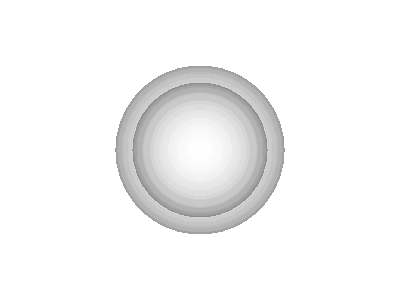

In [14]:
mapper = vtk.vtkPolyDataMapper()
mapper.SetInputData(mesh)

actor = vtk.vtkActor()
actor.SetMapper(mapper)
actor.GetProperty().SetOpacity(0.25)

renderer = vtk.vtkRenderer()
renderer.AddActor(actor)
renderer.SetBackground(1.0, 1.0, 1.0)
vtk_show(renderer)

Set the source and target coordinate of the ray

In [15]:
pSource = [-50.0, 0.0, 0.0]
pTarget = [50.0, 0.0, 0.0]

Use the `addPoint` and `addLine` helper-functions to render the ray as well as the source (red) and target (green) points

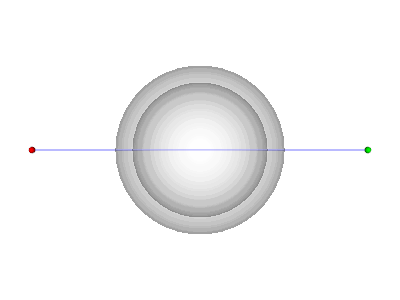

In [16]:
addPoint(renderer, pSource, color=[1.0, 0.0, 0.0])
addPoint(renderer, pTarget, color=[0.0, 1.0, 0.0])
addLine(renderer, pSource, pTarget)
vtk_show(renderer)

Create a `vtkOBBTree` which will allow us to perform ray-casting and get the intersection points between a ray and the `mesh`

In [17]:
obbTree = vtk.vtkOBBTree()
obbTree.SetDataSet(mesh)
obbTree.BuildLocator()

Create a new `vtkPoints` object to store the intersection points found via the ray-casting

In [18]:
pointsVTKintersection = vtk.vtkPoints()

Perform the ray-casting. The `IntersectWithLine` method returns an `int` code which if `0` means that no intersection points were found. If equal to `1` then some points were found. If equal to `-1` then the ray source lies within the surface

In [19]:
obbTree.IntersectWithLine(pSource, pTarget, pointsVTKintersection, None)

1

'Convert' the intersection points into coordinate tuples and store them under the `list` named `pointsIntersection`

In [20]:
pointsVTKIntersectionData = pointsVTKintersection.GetData()
noPointsVTKIntersection = pointsVTKIntersectionData.GetNumberOfTuples()
pointsIntersection = []
for idx in range(noPointsVTKIntersection):
    _tup = pointsVTKIntersectionData.GetTuple3(idx)
    pointsIntersection.append(_tup)

Loop through `pointsIntersection` list and use the `addPoint` helper-function to render the intersection points (blue)

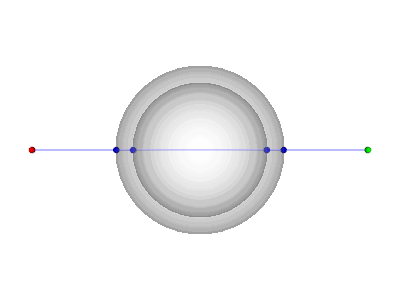

In [21]:
for p in pointsIntersection:
    addPoint(renderer, p, color=[0.0, 0.0, 1.0])
vtk_show(renderer)